# Sonification of non-bonded interaction energy between atoms

As a sonfication strategy, the non-bonded interaction forces (Lennard-Jones and Coulomb) between pairs of atoms were calculated.

The methodology for calculating each individual term was based on the following page: http://docs.openmm.org/6.3.0/userguide/theory.html
(LJ: section 19.6.1 ; Coulomb: section 19.6.2)

The final interaction force was defined as: 

$$Interaction Energy = LJ + C_{dampened}$$

Further details can be found below.

### Calculation of Lennard-Jones Potential

The Lennard-Jones potential was calculated for two atoms, i and j, by the following formula:

$$LJ = 4\epsilon ((\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^{6})$$

Where:

    ɛ is the epsilon term between two atoms, i and j. Where the OpenMMForcefield used has a precalculated value for ɛ (as denoted by there being an exception in the NarupaXR input .xml file), this value is used. However, where no exception exists between two particles, epsilon is calculated by: 
    
$$\epsilon_{ij} = \sqrt{\epsilon_{i}\epsilon_{j}}$$

    σ is the sigma term between two atoms, i and j. Where the OpenMMForcefield used has a precalculated value for σ (as denoted by there being an exception in the NarupaXR input .xml file), this value is used. However, where no exception exists between two particles, sigma is calculated by: 
    
$$\sigma_{ij} = \frac{\sigma_{i} + \sigma_{j}}{2}$$

    r is the distance between the center point of two atoms, i and j 

### Calculation of Coulomb Interaction 

The Coloumb Interaction was calculated for two atoms, i and j, by the following formula:

$$C = \frac{1}{4\pi\epsilon_{0}} \frac{q_{i}q_{j}}{r}$$

Where:
    
    q is the partial charge of an atom
    4πɛ0^-1 is the coulomb constant, 138.935456, in the units of KJ x mol^-1 x nm x e^-2
    r is the distance between the center point of two atoms, i and j
    
Additionally, in order to account for solvent effects, the Coulomb interaction value was dampened by dividing by a solvent dielectric constant, as taken from the GBSAOBC2 implicit solvent model, 78.5: 

$$C_{dampened} = \frac{C}{78.5}$$

### Calculation of interaction energy between two atoms

Below, values for ϵ, σ, and q can be adjusted for two atoms:

In [17]:
import math
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Methods for calculating interaction energy
def create_atom_dict(eps, sig, q):
    atom = dict()
    atom["eps"] = eps
    atom["sig"] = sig
    atom["q"] = q
    
    return atom

def calculate_nonbonded_interaction(atom1, atom2, distance):
    LJ = calculate_LJ(atom1, atom2, distance)
    C = calculate_C(atom1, atom2, distance)
    
    return LJ + C

def calculate_LJ(atom1, atom2, distance):
    eps = calculate_eps(atom1["eps"], atom2["eps"])
    sig = calculate_sig(atom1["sig"], atom2["sig"])
    
    return (4*eps) * ((sig/distance)**12 - (sig/distance)**6)

def calculate_eps(i_eps, j_eps):
    return math.sqrt(i_eps * j_eps)

def calculate_sig(i_sig, j_sig):
    return ((i_sig + j_sig) / 2)

def calculate_C(atom1, atom2, distance):
    ONE_4PI_EPS0 = 138.935456
    solvent_dielectric = 78.5
    q_i = atom1["q"]
    q_j = atom2["q"]
    
    return (ONE_4PI_EPS0) * (((q_i * q_j) / distance) / solvent_dielectric)

# Methods for operating interactive sliders
def update_graph(a1_eps, a2_eps, a1_sig, a2_sig, a1_q, a2_q):
    atom1 = create_atom_dict(a1_eps, a1_sig, a1_q)
    atom2 = create_atom_dict(a2_eps, a2_sig, a2_q)
    
    all_distances = np.arange(2.0, 0.01, -0.001)
    nonbonded_values = []
    distances = []
    limit = 10
    min_interaction = limit
    min_distance = 0
    
    for distance in all_distances:
        nb_interaction = calculate_nonbonded_interaction(atom1, atom2, distance)
        nonbonded_values.append(nb_interaction) 
        distances.append(distance)
        
        if nb_interaction < min_interaction:
            min_interaction = nb_interaction
            min_distance = distance 
        
        if nb_interaction > limit:
            break
            
    make_graph(distances, nonbonded_values, min_distance, min_interaction)
            

def make_graph(x, y, x_min, y_min):
    min_text = "Minimum: " + str(round(y_min, 2)) + " kJ/mol"
    if x_min == 0.5:
        min_text += " (capped at 0.5nm)"
    else:
        min_text += " at " + str(round(x_min,2)) + " nm"
            
    plt.plot(x, y, linewidth=3, zorder=5)
    plt.grid(color="white", zorder=3)
    plt.ylabel("Interaction Energy (kJ/mol)", fontsize=12)
    plt.xlabel("Distance (nm)", fontsize=12)
    plt.title(min_text, fontsize=12)
    ax = plt.gca()
    ax.set_facecolor([0.9, 0.9, 0.9])
    ax.axhline(y=0, color=[0.3,0.3,0.3], zorder=2)
    ax.axhline(y=y_min, linestyle = "--", color = [0.3,0.3,0.3], zorder=2)
    ax.set_ylim([-10, 10])
    ax.set_xlim([0, 2.0])

interactive(children=(FloatSlider(value=0.07, continuous_update=False, description='ɛ (1):', max=1.0, min=0.01…

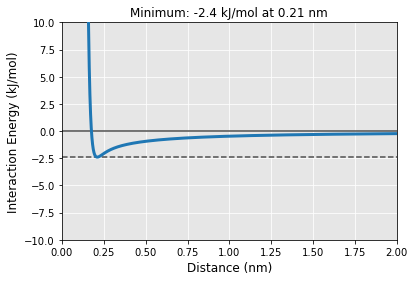

In [18]:
print('\n\n')
#Define variables for two atoms, i and j
atom_i = create_atom_dict(0.066, 0.107, 0.327)
atom_j = create_atom_dict(0.879, 0.296, -0.801)

#sliders for epsilon values
a1_eps = widgets.FloatSlider(value=0.07, min=0.01, max=1.0, step=0.01, continuous_update=False, description="ɛ (1):")
a2_eps = widgets.FloatSlider(value=0.88, min=0.01, max=1.0, step=0.01, continuous_update=False, description="ɛ (2):")
#sliders for sigma
a1_sig = widgets.FloatSlider(value=0.11, min=0.01, max=1.0, step=0.01, continuous_update=False, description="σ (1):")
a2_sig = widgets.FloatSlider(value=0.29, min=0.01, max=1.0, step=0.01, continuous_update=False, description="σ (2):")
#sliders for q
a1_q = widgets.FloatSlider(value=0.33, min=-1.0, max=1.0, step=0.01, continuous_update=False, description="q (1):")
a2_q = widgets.FloatSlider(value=-0.8, min=-1.0, max=1.0, step=0.01, continuous_update=False, description="q (2):")

interact(update_graph, a1_eps=a1_eps, a2_eps=a2_eps, a1_sig=a1_sig, a2_sig=a2_sig, a1_q=a1_q, a2_q=a2_q)

update_graph(a1_eps=0.06568, a2_eps=0.87864, a1_sig=0.1069, a2_sig=0.29599, a1_q=0.3267, a2_q=-0.81)


## Examples

### Non-bonded interaction between water molecules

ϵ, σ, and q values between oxygen and hydrogen in the TIP3P water model was used to calculate the minimum energy of a nonbonding interactions between two water molecules. Values taken from http://www1.lsbu.ac.uk/water/water_models.html

Individual values for ϵ and σ was calculated by decomposing the combined values reported in the above source into pairs that evaluate back to the original combined value when put in the Lennard-Jones potential equation.  

ϵ_oxygen = 0.6364<sup>2</sup> = 0.4055

ϵ_hydrogen = 0


σ_oxygen = 2 * 0.31506 = 0.63012

σ_hydrogen = 1


q_oxygen = -0.834

q_hydrogen = 0.417 

The minimum nonbonded interaction energy was found to be -2.4 kJ/mol at a distance of 0.34 nm. 


In [ ]:

#decompose the combined ϵ and σ terms into two seperate values
e_o = 0.6364**2
e_h = 1
s_o = 0.315061*2
s_h = 0
q_o = -0.834
q_h = 0.417

oxygen = create_atom_dict(e_o, s_o, q_o)
hydrogen = create_atom_dict(e_h, s_h, q_h)

all_distances = np.arange(0.5, 0.01, -0.01)
values = []
distances = []
limit = 10
min_interaction = limit
min_distance = 0
    
for distance in all_distances:
    oh_interaction = calculate_nonbonded_interaction(oxygen, hydrogen, distance)
    values.append(oh_interaction)
    distances.append(distance)
    
    if oh_interaction < min_interaction:
        min_interaction = oh_interaction
        min_distance = distance 
        
    if oh_interaction > limit:
        break

make_graph(distances, values, min_distance, min_interaction)
  


## Non-bonded interaction in protein alpha helix

The same can be repeated for a hydrogen bond in a protein alpha helix, using parameters from the Amber14 forcefield. 

ϵ_oxygen = 0.87864
ϵ_hydrogen = 0.06569
σ_oxygen = 0.29599
σ_hydrogen = 0.10691
q_oxygen = -0.5679
q_hydrogen = 0.2719 


In [ ]:
e_o = 0.87864
e_h = 0.06569
s_o = 0.29599
s_h = 0.10691
q_o = -0.5679 
q_h = 0.2719 

oxygen = create_atom_dict(e_o, s_o, q_o)
hydrogen = create_atom_dict(e_h, s_h, q_h)

all_distances = np.arange(0.5, 0.01, -0.01)
values = []
distances = []
limit = 10
min_interaction = limit
min_distance = 0
    
for distance in all_distances:
    oh_interaction = calculate_nonbonded_interaction(oxygen, hydrogen, distance)
    values.append(oh_interaction)
    distances.append(distance)
    
    if oh_interaction < min_interaction:
        min_interaction = oh_interaction
        min_distance = distance 
        
    if oh_interaction > limit:
        break

make_graph(distances, values, min_distance, min_interaction)